In [2]:
import pandas as pd
import numpy as np
import holidays
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OrdinalEncoder
from matplotlib import pyplot as plt
from datetime import datetime
import requests
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")

In [3]:
df_train = pd.read_csv("train.csv", index_col="id")
df_test = pd.read_csv("test.csv", index_col="id")
df_train["date"]= pd.to_datetime(df_train["date"])
df_test["date"]= pd.to_datetime(df_test["date"])

In [4]:
countries = df_train["country"].unique().tolist()

In [5]:
# Precompute all holidays for these countries (2010–2016)
holiday_set = set()

for country in countries:
    # Generate holidays for the country between 2010 and 2016
    country_holidays = holidays.CountryHoliday(country, years=range(2010, 2020))
    # Store dates as strings for fast lookup
    for date in country_holidays:
        holiday_set.add((country, date.strftime("%Y-%m-%d")))

In [6]:
# Check if (country, date) is a holiday
df_train["is_holiday"] = df_train.apply(
    lambda row: 1 if (row["country"], row["date"].strftime("%Y-%m-%d")) in holiday_set else 0,
    axis=1
)

In [7]:
df_test["is_holiday"] = df_test.apply(
    lambda row: 1 if (row["country"], row["date"].strftime("%Y-%m-%d")) in holiday_set else 0,
    axis=1
)

In [8]:
df_train.groupby("country")["is_holiday"].value_counts()

country    is_holiday
Canada     0             37755
           1               600
Finland    0             36780
           1              1575
Italy      0             37095
           1              1260
Kenya      0             37275
           1              1080
Norway     0             37110
           1              1245
Singapore  0             36990
           1              1365
Name: count, dtype: int64

In [9]:
df_test.groupby("country")["is_holiday"].value_counts()

country    is_holiday
Canada     0             16185
           1               240
Finland    0             15750
           1               675
Italy      0             15885
           1               540
Kenya      0             15960
           1               465
Norway     0             15885
           1               540
Singapore  0             15840
           1               585
Name: count, dtype: int64

In [10]:
df_test['day_of_week'] = df_test['date'].dt.dayofweek
df_test['month'] = df_test['date'].dt.month
df_test['year'] = df_test['date'].dt.year
df_test['day'] = df_test['date'].dt.day
df_test['week_of_year'] = df_test['date'].dt.isocalendar().week

In [11]:
df_train['day_of_week'] = df_train['date'].dt.dayofweek
df_train['month'] = df_train['date'].dt.month
df_train['year'] = df_train['date'].dt.year
df_train['day'] = df_train['date'].dt.day
df_train['week_of_year'] = df_train['date'].dt.isocalendar().week

In [12]:
# 4. Categorical interactions
df_train["country_store_product"] = (
    df_train["country"] + "_" + df_train["store"] + "_" + df_train["product"])

In [13]:

df_test["country_store_product"] = (
    df_test["country"] + "_" + df_test["store"] + "_" + df_test["product"])

In [14]:
df_train

,date,country,store,product,num_sold,is_holiday,day_of_week,month,year,day,week_of_year,country_store_product
id,,,,,,,,,,,,
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,1,4,1,2010,1,53,Canada_Discount Stickers_Holographic Goose
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,1,4,1,2010,1,53,Canada_Discount Stickers_Kaggle
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,1,4,1,2010,1,53,Canada_Discount Stickers_Kaggle Tiers
3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,1,4,1,2010,1,53,Canada_Discount Stickers_Kerneler
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,1,4,1,2010,1,53,Canada_Discount Stickers_Kerneler Dark Mode
...,...,...,...,...,...,...,...,...,...,...,...,...
230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0,0,5,12,2016,31,52,Singapore_Premium Sticker Mart_Holographic Goose
230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0,0,5,12,2016,31,52,Singapore_Premium Sticker Mart_Kaggle
230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0,0,5,12,2016,31,52,Singapore_Premium Sticker Mart_Kaggle Tiers


In [15]:
df_train.describe()

,date,num_sold,is_holiday,day_of_week,month,year,day,week_of_year
count,230130,221259.000000,230130.000000,230130.000000,230130.000000,230130.000000,230130.000000,230130.0
mean,2013-07-02 00:00:00,752.527382,0.030961,3.001173,6.522487,2013.000782,15.730935,26.593664
min,2010-01-01 00:00:00,5.000000,0.000000,0.000000,1.000000,2010.000000,1.000000,1.0
25%,2011-10-02 00:00:00,219.000000,0.000000,1.000000,4.000000,2011.000000,8.000000,14.0
50%,2013-07-02 00:00:00,605.000000,0.000000,3.000000,7.000000,2013.000000,16.000000,27.0
75%,2015-04-02 00:00:00,1114.000000,0.000000,5.000000,10.000000,2015.000000,23.000000,40.0
max,2016-12-31 00:00:00,5939.000000,1.000000,6.000000,12.000000,2016.000000,31.000000,53.0
std,NaN,690.165445,0.173212,1.999711,3.448832,2.000200,8.800659,15.064577


In [16]:
df_train.isnull().sum()

date                        0
country                     0
store                       0
product                     0
num_sold                 8871
is_holiday                  0
day_of_week                 0
month                       0
year                        0
day                         0
week_of_year                0
country_store_product       0
dtype: int64

In [17]:
df_train.duplicated().sum()

0

In [18]:
df_train["interpol_num_sold"] = (df_train["num_sold"].interpolate(method="linear"))

<Axes: ylabel='Density'>

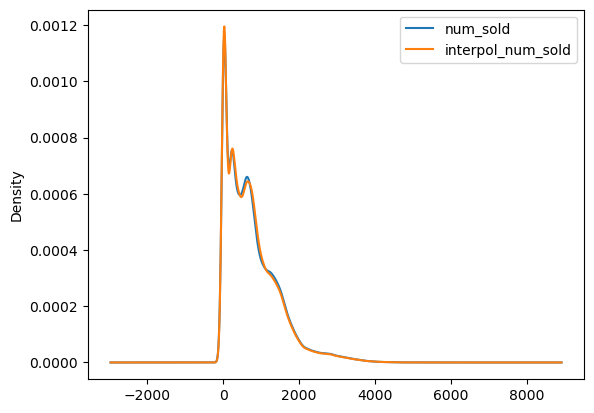

In [19]:
df_train[["num_sold","interpol_num_sold"]].plot(kind="kde")

In [20]:
df_train.drop(columns=["num_sold"], inplace=True)

In [21]:
df_train.fillna(df_train[(df_train["country"] == "Canada") & (df_train["product"] == "Holographic Goose")]["interpol_num_sold"].mean(), inplace=True)

In [22]:
df_train

,date,country,store,product,is_holiday,day_of_week,month,year,day,week_of_year,country_store_product,interpol_num_sold
id,,,,,,,,,,,,
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,1,4,1,2010,1,53,Canada_Discount Stickers_Holographic Goose,597.632203
1,2010-01-01,Canada,Discount Stickers,Kaggle,1,4,1,2010,1,53,Canada_Discount Stickers_Kaggle,973.000000
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,1,4,1,2010,1,53,Canada_Discount Stickers_Kaggle Tiers,906.000000
3,2010-01-01,Canada,Discount Stickers,Kerneler,1,4,1,2010,1,53,Canada_Discount Stickers_Kerneler,423.000000
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,1,4,1,2010,1,53,Canada_Discount Stickers_Kerneler Dark Mode,491.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,0,5,12,2016,31,52,Singapore_Premium Sticker Mart_Holographic Goose,466.000000
230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,0,5,12,2016,31,52,Singapore_Premium Sticker Mart_Kaggle,2907.000000
230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,0,5,12,2016,31,52,Singapore_Premium Sticker Mart_Kaggle Tiers,2299.000000


In [23]:
df_test

,date,country,store,product,is_holiday,day_of_week,month,year,day,week_of_year,country_store_product
id,,,,,,,,,,,
230130,2017-01-01,Canada,Discount Stickers,Holographic Goose,1,6,1,2017,1,52,Canada_Discount Stickers_Holographic Goose
230131,2017-01-01,Canada,Discount Stickers,Kaggle,1,6,1,2017,1,52,Canada_Discount Stickers_Kaggle
230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers,1,6,1,2017,1,52,Canada_Discount Stickers_Kaggle Tiers
230133,2017-01-01,Canada,Discount Stickers,Kerneler,1,6,1,2017,1,52,Canada_Discount Stickers_Kerneler
230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode,1,6,1,2017,1,52,Canada_Discount Stickers_Kerneler Dark Mode
...,...,...,...,...,...,...,...,...,...,...,...
328675,2019-12-31,Singapore,Premium Sticker Mart,Holographic Goose,0,1,12,2019,31,1,Singapore_Premium Sticker Mart_Holographic Goose
328676,2019-12-31,Singapore,Premium Sticker Mart,Kaggle,0,1,12,2019,31,1,Singapore_Premium Sticker Mart_Kaggle
328677,2019-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,0,1,12,2019,31,1,Singapore_Premium Sticker Mart_Kaggle Tiers


In [24]:
df_train["product"].value_counts()

product
Holographic Goose     46026
Kaggle                46026
Kaggle Tiers          46026
Kerneler              46026
Kerneler Dark Mode    46026
Name: count, dtype: int64

In [25]:
print(df_test.head())
print(df_train.head())

             date country              store             product  is_holiday  \
id                                                                             
230130 2017-01-01  Canada  Discount Stickers   Holographic Goose           1   
230131 2017-01-01  Canada  Discount Stickers              Kaggle           1   
230132 2017-01-01  Canada  Discount Stickers        Kaggle Tiers           1   
230133 2017-01-01  Canada  Discount Stickers            Kerneler           1   
230134 2017-01-01  Canada  Discount Stickers  Kerneler Dark Mode           1   

        day_of_week  month  year  day  week_of_year  \
id                                                    
230130            6      1  2017    1            52   
230131            6      1  2017    1            52   
230132            6      1  2017    1            52   
230133            6      1  2017    1            52   
230134            6      1  2017    1            52   

                              country_store_product  

In [26]:
cat_cols = ['country', 'store', 'product','country_store_product']

In [27]:
df_train[cat_cols]=df_train[cat_cols].astype("category")
df_test[cat_cols]=df_test[cat_cols].astype("category")

In [28]:
train_X= df_train.drop(columns= ['date','interpol_num_sold'])
train_y=df_train["interpol_num_sold"]
test_X = df_test.drop(columns=["date"])

In [29]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230130 entries, 0 to 230129
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   country                230130 non-null  category
 1   store                  230130 non-null  category
 2   product                230130 non-null  category
 3   is_holiday             230130 non-null  int64   
 4   day_of_week            230130 non-null  int32   
 5   month                  230130 non-null  int32   
 6   year                   230130 non-null  int32   
 7   day                    230130 non-null  int32   
 8   week_of_year           230130 non-null  UInt32  
 9   country_store_product  230130 non-null  category
dtypes: UInt32(1), category(4), int32(4), int64(1)
memory usage: 9.0 MB


In [30]:
X_train,X_val,y_train,y_val= train_test_split(train_X,train_y,test_size=0.2,random_state=42)

In [31]:
lgm = LGBMRegressor(categorical_feature=cat_cols)
scores= cross_val_score(lgm,X_train,y_train,cv=5,scoring="r2")
print(scores.mean())

[LightGBM] [Warning] categorical_feature is set=country,store,product,country_store_product, categorical_column=0,1,2,9 will be ignored. Current value: categorical_feature=country,store,product,country_store_product
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 147283, number of used features: 10
[LightGBM] [Info] Start training from score 743.499383
[LightGBM] [Warning] categorical_feature is set=country,store,product,country_store_product, categorical_column=0,1,2,9 will be ignored. Current value: categorical_feature=country,store,product,country_store_product
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005515 seconds.
You can set `force_row_wise=true` to remove the overhead

In [32]:
lgm1=lgm.fit(X_train,y_train)
feature_imp = pd.DataFrame({
    "feature":X_train.columns,
    "LGBM_importance": lgm1.feature_importances_
}).sort_values(by="LGBM_importance", ascending = False)


[LightGBM] [Warning] categorical_feature is set=country,store,product,country_store_product, categorical_column=0,1,2,9 will be ignored. Current value: categorical_feature=country,store,product,country_store_product
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 10
[LightGBM] [Info] Start training from score 743.300274


In [33]:
feature_imp

,feature,LGBM_importance
9,country_store_product,1123
8,week_of_year,549
6,year,528
4,day_of_week,259
5,month,188
2,product,141
7,day,81
0,country,63
1,store,63
3,is_holiday,5


In [34]:
lgm.fit(X_train,y_train)

[LightGBM] [Warning] categorical_feature is set=country,store,product,country_store_product, categorical_column=0,1,2,9 will be ignored. Current value: categorical_feature=country,store,product,country_store_product
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 10
[LightGBM] [Info] Start training from score 743.300274


LGBMRegressor(categorical_feature=['country', 'store', 'product',
                                   'country_store_product'])

In [35]:
y_pred = lgm.predict(X_val)

In [36]:
mean_absolute_percentage_error(y_val, y_pred)

0.09389471977208004

In [37]:
y_test=lgm.predict(test_X)

In [38]:
test_X["pred_num_sold"] =y_test.round(1)

In [39]:
test_X.columns

Index(['country', 'store', 'product', 'is_holiday', 'day_of_week', 'month',
       'year', 'day', 'week_of_year', 'country_store_product',
       'pred_num_sold'],
      dtype='object')

In [40]:
test_X.drop(columns=['country', 'store', 'product', 'is_holiday', 'day_of_week', 'month',
       'year', 'day', 'week_of_year','country_store_product'],inplace= True)

In [41]:
test_X.to_csv("sticker_sales_forecast3.csv", index=True) 

In [42]:
test_X

,pred_num_sold
id,
230130,1061.0
230131,868.3
230132,766.2
230133,417.1
230134,472.5
...,...
328675,375.5
328676,2252.2
328677,1853.3
